In [2]:
%matplotlib inline

from joblib import dump, load
import itertools
import json
import math
import os
import random
import time
from typing import Callable, Dict, List

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# scikit-learn
import sklearn
from sklearn.base import clone
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, \
    f1_score, fbeta_score, log_loss, make_scorer, precision_recall_fscore_support, \
    precision_score, precision_recall_curve, recall_score
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Models
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor


# NLP
import gc
import re
import string
import operator
from collections import defaultdict



# Configure options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 11

random.seed(random_state)
np.random.seed(random_state)

In [3]:
root = '/home/jovyan/work'

# Part I - EDA

## Section - Data correctness

In [31]:
def get_types(df):
    dtypes = defaultdict(list)
    for col, dtype in df.dtypes.items():
        dtypes[str(dtype)].append(col)
    return dtypes

In [79]:
pc = pd.read_csv(root + '/Downloads/procedure_codes.csv')

In [5]:
pc.describe()

,procedure_code,description,metadata
count,705,705,705
unique,705,703,48
top,D6612,Malar and/or zygomatic arch - open reduction,"{""tier"": ""NOT_COVERED"", ""sub_category"": ""NOT_C..."
freq,1,2,164


In [6]:
pc

,procedure_code,description,metadata
0,D0120,Periodic oral evaluation - established patient,"{""tier"": ""TIER_1"", ""unit"": 1, ""sub_category"": ..."
1,D0140,Limited oral evaluation - problem focused,"{""tier"": ""TIER_1"", ""unit"": 1, ""sub_category"": ..."
2,D0145,Oral evaluation for a patient under three year...,"{""tier"": ""TIER_1"", ""unit"": 1, ""sub_category"": ..."
3,D0150,Comprehensive oral evaluation - new or establi...,"{""tier"": ""TIER_1"", ""unit"": 1, ""sub_category"": ..."
4,D0160,Detailed and extensive oral evaluation - probl...,"{""tier"": ""TIER_1"", ""unit"": 1, ""sub_category"": ..."
...,...,...,...
700,D9993,Dental case management - motivational intervie...,"{""tier"": ""NOT_COVERED"", ""sub_category"": ""NOT_C..."
701,D9994,Dental case management - patients education to...,"{""tier"": ""NOT_COVERED"", ""sub_category"": ""NOT_C..."
702,D9995,Teledentistry - synchronous: real-time encounter,"{""tier"": ""NOT_COVERED"", ""sub_category"": ""NOT_C..."
703,D9996,Teledentistry - synchronous: information store...,"{""tier"": ""NOT_COVERED"", ""sub_category"": ""NOT_C..."


In [80]:
# Flatten json data
import json
metadata = pd.json_normalize(pc['metadata'].apply(json.loads))

pc = pc.join(metadata).drop(['metadata'], axis=1)
pc

,procedure_code,description,tier,unit,sub_category,coverage_category,excluded_if_present_codes
0,D0120,Periodic oral evaluation - established patient,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
1,D0140,Limited oral evaluation - problem focused,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
2,D0145,Oral evaluation for a patient under three year...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
3,D0150,Comprehensive oral evaluation - new or establi...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
4,D0160,Detailed and extensive oral evaluation - probl...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
...,...,...,...,...,...,...,...
700,D9993,Dental case management - motivational intervie...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED,NaN
701,D9994,Dental case management - patients education to...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED,NaN
702,D9995,Teledentistry - synchronous: real-time encounter,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED,NaN
703,D9996,Teledentistry - synchronous: information store...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED,NaN


In [43]:
pc[~pc['excluded_if_present_codes'].isna()]

,procedure_code,description,tier,unit,sub_category,coverage_category,excluded_if_present_codes
11,D0220,Intraoral - periapical first radiographic image,TIER_1,1.0,XRAY,XRAY,[D0210]
12,D0230,Intraoral - periapical each additional radiogr...,TIER_1,1.0,XRAY,XRAY,[D0210]
13,D0240,Intraoral - occlusal radiographic image,TIER_1,1.0,XRAY,XRAY,[D0210]
16,D0270,Bitewing - single radiographic image,TIER_1,1.0,BITEWING,XRAY,[D0210]
17,D0272,Bitewings - two radiographic images,TIER_1,2.0,BITEWING,XRAY,[D0210]
18,D0273,Bitewings - three radiographic images,TIER_1,3.0,BITEWING,XRAY,[D0210]
19,D0274,Bitewings - four radiographic images,TIER_1,4.0,BITEWING,XRAY,[D0210]
20,D0277,Vertical bitewings - 7 to 8 radiographic images,TIER_1,7.0,BITEWING,XRAY,[D0210]


In [63]:
# Only unit and excluded_if_present_codes are NA
pc[pc.isna().any(axis=1)]

,procedure_code,description,tier,unit,sub_category,coverage_category,excluded_if_present_codes
0,D0120,Periodic oral evaluation - established patient,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
1,D0140,Limited oral evaluation - problem focused,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
2,D0145,Oral evaluation for a patient under three year...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
3,D0150,Comprehensive oral evaluation - new or establi...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
4,D0160,Detailed and extensive oral evaluation - probl...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION,NaN
...,...,...,...,...,...,...,...
700,D9993,Dental case management - motivational intervie...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED,NaN
701,D9994,Dental case management - patients education to...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED,NaN
702,D9995,Teledentistry - synchronous: real-time encounter,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED,NaN
703,D9996,Teledentistry - synchronous: information store...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED,NaN


In [68]:
for col in pc.columns:
    print(col)
    print(len(pc[pc[col].isna()]))

procedure_code
0
description
0
tier
0
unit
486
sub_category
0
coverage_category
0
excluded_if_present_codes
697


In [83]:
pc[~pc['excluded_if_present_codes'].isna()]

,procedure_code,description,tier,unit,sub_category,coverage_category,excluded_if_present_codes
11,D0220,Intraoral - periapical first radiographic image,TIER_1,1.0,XRAY,XRAY,[D0210]
12,D0230,Intraoral - periapical each additional radiogr...,TIER_1,1.0,XRAY,XRAY,[D0210]
13,D0240,Intraoral - occlusal radiographic image,TIER_1,1.0,XRAY,XRAY,[D0210]
16,D0270,Bitewing - single radiographic image,TIER_1,1.0,BITEWING,XRAY,[D0210]
17,D0272,Bitewings - two radiographic images,TIER_1,2.0,BITEWING,XRAY,[D0210]
18,D0273,Bitewings - three radiographic images,TIER_1,3.0,BITEWING,XRAY,[D0210]
19,D0274,Bitewings - four radiographic images,TIER_1,4.0,BITEWING,XRAY,[D0210]
20,D0277,Vertical bitewings - 7 to 8 radiographic images,TIER_1,7.0,BITEWING,XRAY,[D0210]


In [82]:
# pc[~pc['excluded_if_present_codes'].isna()]['excluded_if_present_codes'] = 'D0210'
# pc[pc['excluded_if_present_codes'] == 'D0210']

/opt/conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,procedure_code,description,tier,unit,sub_category,coverage_category,excluded_if_present_codes


In [47]:
# Most likely no duplicates
pc[pc.drop('excluded_if_present_codes', axis=1).duplicated()]

,procedure_code,description,tier,unit,sub_category,coverage_category,excluded_if_present_codes


In [27]:
c = pd.read_csv(root + '/Downloads/claims.csv')
c.describe()

,provider_zipcode,procedure_charge
count,9.336880e+06,9.336880e+06
mean,9.329451e+04,1.569287e+02
std,1.763912e+03,3.792115e+02
min,9.125000e+03,0.000000e+00
25%,9.206400e+04,4.300000e+01
50%,9.330900e+04,7.900000e+01
75%,9.470600e+04,1.400000e+02
max,9.862800e+04,9.999900e+04


In [48]:
c[c.isna().any(axis=1)]

,claim_date,patient_id,provider_zipcode,procedure_code,procedure_charge


In [50]:
len(c)

9336880

In [49]:
# Lots of duplicates
c[c.duplicated()]

,claim_date,patient_id,provider_zipcode,procedure_code,procedure_charge
21,2016-10-25,e9db4a8947,95037,D2393,167.0
24,2017-12-11,f7975dc019,94558,D2393,304.0
45,2017-05-15,7accefc583,95207,D2740,678.0
51,2017-08-09,ec8c887b51,92614,D0350,90.0
132,2016-02-04,e7da6ec218,94040,D2391,199.0
...,...,...,...,...,...
9336859,2017-06-20,65781bc509,92308,D1351,45.0
9336862,2019-07-24,bf6dd9bf9f,92335,D0230,40.0
9336863,2018-07-12,de5204a099,93030,D0230,35.0
9336871,2019-06-07,9d1085420d,90255,D0230,30.0


In [51]:
# Sanity check one of the duplicates
c[c['patient_id'] == 'e9db4a8947']

,claim_date,patient_id,provider_zipcode,procedure_code,procedure_charge
20,2016-10-25,e9db4a8947,95037,D2393,167.0
21,2016-10-25,e9db4a8947,95037,D2393,167.0
98,2016-10-25,e9db4a8947,95037,D7140,88.0
1776,2016-10-25,e9db4a8947,95037,D1510,238.0
1883,2016-10-25,e9db4a8947,95037,D2930,137.0
1919,2016-10-25,e9db4a8947,95037,D2930,137.0
1991,2016-10-25,e9db4a8947,95037,D2930,137.0
2803,2016-10-25,e9db4a8947,95037,D3220,78.0
2978,2016-10-25,e9db4a8947,95037,D2332,109.0
2996,2016-10-25,e9db4a8947,95037,D1510,238.0


In [52]:
# Drop duplicates
c = c.drop_duplicates()

In [53]:
# Sanity check output
len(c)

7761720

In [161]:
for code in c['procedure_code'].unique():
    print(code)

D2740
D0274
D2393
D0220
D0120
D2392
D1208
D1206
D9223
D0350
D1120
D2391
D4341
D4910
D7210
D1351
D9230
D1110
D7140
D0230
D0150
D1330
D7240
D0460
D4999
D0340
D0272
D9310
D0330
D0140
D0145
D2950
D9910
D2150
D4921
01120
D2330
D1000
D3330
D2332
D3221
D9110
D6066
D8670
D7230
D3347
D2750
D4342
D6058
D2335
D2751
D2954
D6057
D7953
D5140
D6010
D2792
D8090
D9248
D2930
D2394
D3320
D2140
D2752
D5751
D7880
D2783
D3220
D2952
D2790
D5982
D6065
D3120
D9610
D9940
D5214
D7111
D0005
D5650
D0602
D7220
D6068
D6240
D4267
D9222
D0383
00120
D9220
D5862
D0210
D4261
D5110
D4260
D3240
00003
D8660
D1203
D3310
D2962
D0367
D6059
D0180
D6056
D0470
D0425
D9242
00230
D6750
D3110
D6752
D2160
D9221
D6930
D2644
D9944
D2920
D8080
D2791
D0431
D0999
D9120
ASLAS
D9241
D0603
D4283
D0270
D2331
D1555
D9430
D9410
D9630
01351
D1204
D0277
D5120
D1510
D7241
02150
D7250
D2643
D4211
00210
D7951
D5211
D5610
D3331
D4265
D7320
D5130
D2940
D0366
D2161
D6190
D6103
D4212
D5212
D4266
D7251
D0365
D4263
D4273
D5510
D5820
D0601
D8070
D7310
D438

In [162]:
for code in c['procedure_code'].unique():
    if len(code) != 5 or not code.startswith('D'):
        print(code)

01120
00120
00003
00230
ASLAS
01351
02150
00210
01208
00272
02140
02751
1206
02954
00150
00TAX
00603
02391
09993
00274
07111
01310
09230
X0020
01110
01206
00350
03310
05120
03330
00145
09430
07140
05110
01510
03220
09248
02930
00220
02931
03320
00270
FMP
02392
PROBE
02394
PCH
07210
00330
CRWNPRC
02160
20001
07240
05211
02920
07230
04341
00602
01204
02331
49995
02330
02161
INV00
D8080I
02332
02393
NS2
LASER
55555
CEM
05214
CEMBR
01330
05750
00601
LC
05751
03352
CK IN
DEL SM
PERID
09999
ER020
B013
99999
02932
FML
10010
D2391.1
D120
05850
REC
5640
00002
ORACA
07280
15555
61563
LCC
99889
99992
0230.
07510
D13
04910
IRRIG
90620
03221
HH
L4342
PERSCL1
90016
01515
F0270
T3003
4265E
03351
7451
07220
08692
99070
R69
05212
03110
4 BWX
CHILD P
COMP EX
FTV
SPRYR
TMJ
PEVAL
MEDHX
35468
TB
ORCAN
CEMEN
00240
LABFE
BLEAC
10013
02335
AREST
9430.
MIPAS
99214
DELC
CHLOR
REM C
94760
99213
3
WALK/BL
ORTHORE
ZIRCO
SRPRE
POLIS
01555
130.6
OFFIC
99942
00004
07310
P0001
1208
01550
FAIL
D059
08670
GINGM
RESEA
CL

In [165]:
for code in c['procedure_code'].unique():
    if len(code) != 5:
        print(code)

1206
FMP
PCH
CRWNPRC
D8080I
NS2
CEM
LC
DEL SM
B013
FML
D2391.1
D120
REC
5640
LCC
D13
HH
PERSCL1
7451
R69
CHILD P
COMP EX
FTV
TMJ
TB
DELC
3
WALK/BL
ORTHORE
1208
FAIL
D059
LAVA
LBR
POSTOP
BP
TEMP
ORAQ
UP
RESCMP2
REDO
D9110.L
MHU
POST
SCRN
C7
D200
ENDO
FMX
COMPEX
GRAT
OCS
DEL
RTCNTHR
T2
P108
MEMB
PREV
CD
D28
DED
D2740D
A100
ABA
ERA
ABAMINO
PROPHYA
PERIODI
D140
EMAX
RTNR
99SP
SEAT
D005
VE
STER
PC
D8
D220
000BLE
BA
.
4B
PORC
HIGH
N2O
MTAD
FMPC
D021
RTOE
KIDS
LATE
RC
PHTO
CEMCRN
PF
PO
DHYG
P38
CRNG
D01
PC34
D868
D111
RB
CHLO
OPEN
OPA
IMCC
050A
DR K
RECALL
QS
EXAM
RESCMP1
PEDO
NS
D110
BRUX
INFO
ADJ
HEAL
CMT
CA
REF
ARR
D100
IMP
JAW
HSG
D210
D101
D042
OHI
HEXL
PFG
GSG
FLOURID
LAB
CTX4
IMP SM
REC1
E01011
PROPHY
+PA
BWX4
EX
PA
D272
DNG
GEL
PMR
RESPOST
SEALANT
PHOTOS
D230
GBR
D274
PROB
99RC
AMOX
TC
DDS9
D00610
DA99
D180
0000
PERIDEX
00PR
D70
RESIN3
RES4/IN
D943
D470
NDK
SEC
TRAY
CG
LAN
PC32
SA2
MISC
NDEL
C9
EMP
D109
D7
D402
NU23
6PTS
HHU
PC10
CU
D999
D062
LGR
RNG
D010
D09310
MISS
NTO
VIVA
SBL
PERG

In [173]:
# Lots of procedure codes in the claims that aren't in the record of procedure codes. 
# TODO - are these valid procedures? Probably. Reconcile these sources of data. Update the procedure codes.

cpc = set(c['procedure_code'].unique())
pcpc = set(pc['procedure_code'].unique())

print(len(cpc - pcpc))
print(len(pcpc - cpc))

1375
94


In [164]:
# TODO - check for special characters, consider trimming whitespace
# 'f d'.replace(" ", "-").replace()

'f_d'

## Section - Trends

In [96]:
pc

,procedure_code,description,tier,unit,sub_category,coverage_category
0,D0120,Periodic oral evaluation - established patient,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
1,D0140,Limited oral evaluation - problem focused,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
2,D0145,Oral evaluation for a patient under three year...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
3,D0150,Comprehensive oral evaluation - new or establi...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
4,D0160,Detailed and extensive oral evaluation - probl...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
...,...,...,...,...,...,...
700,D9993,Dental case management - motivational intervie...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
701,D9994,Dental case management - patients education to...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
702,D9995,Teledentistry - synchronous: real-time encounter,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
703,D9996,Teledentistry - synchronous: information store...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED


In [57]:
get_types(pc)

defaultdict(list,
            {'object': ['procedure_code',
              'description',
              'tier',
              'sub_category',
              'coverage_category',
              'excluded_if_present_codes'],
             'float64': ['unit']})

In [58]:
get_types(c)

defaultdict(list,
            {'object': ['claim_date', 'patient_id', 'procedure_code'],
             'int64': ['provider_zipcode'],
             'float64': ['procedure_charge']})

In [84]:
pc = pc.drop('excluded_if_present_codes', axis=1)

In [85]:
for col in pc.columns:
    print(col)
    
    print(len(pc[col].unique()))

procedure_code
705
description
703
tier
5
unit
6
sub_category
28
coverage_category
22


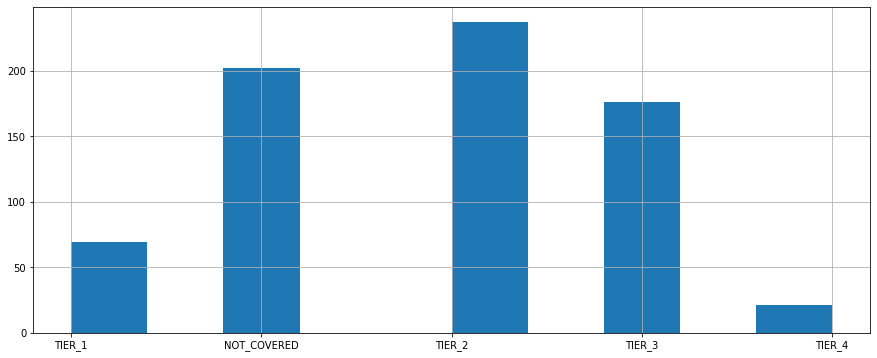

In [97]:
f, ax = plt.subplots(figsize=(15, 6))
pc['tier'].hist()

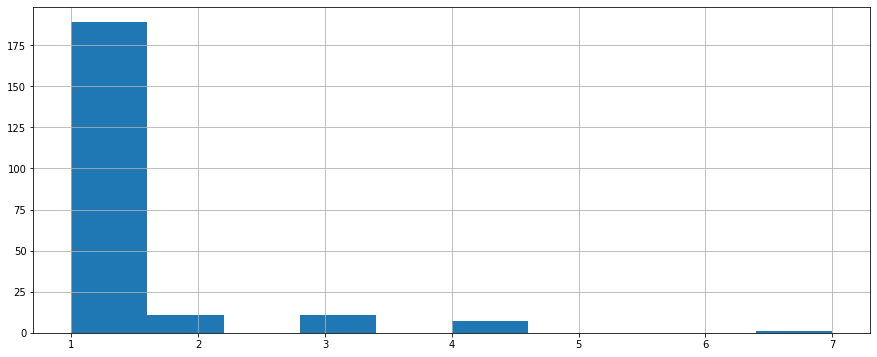

In [91]:
f, ax = plt.subplots(figsize=(15, 6))
pc['unit'].hist()

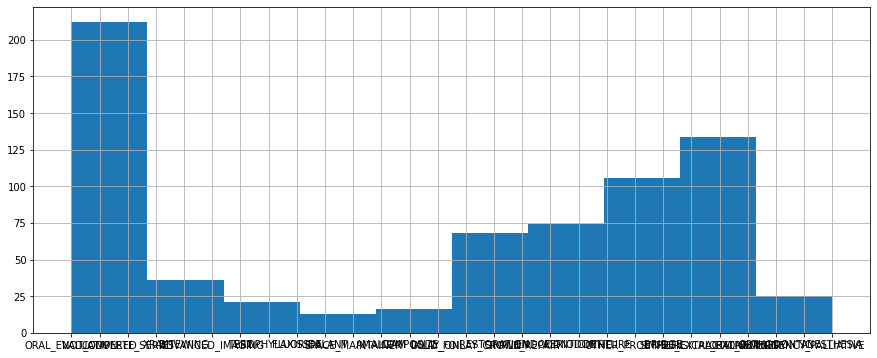

In [92]:
f, ax = plt.subplots(figsize=(15, 6))
pc['sub_category'].hist()

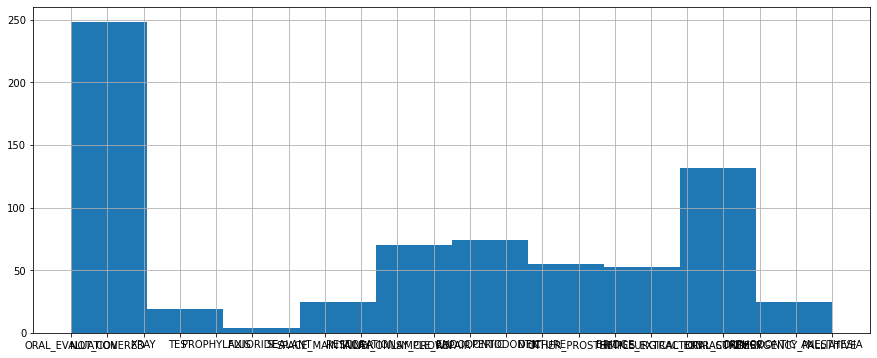

In [93]:
f, ax = plt.subplots(figsize=(15, 6))
pc['coverage_category'].hist()

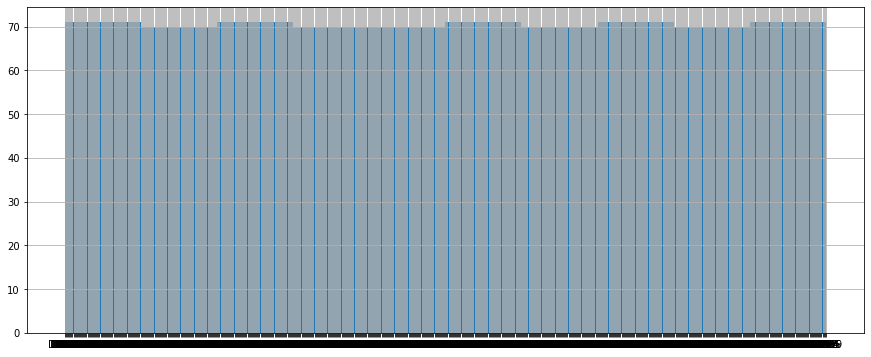

In [95]:
f, ax = plt.subplots(figsize=(15, 6))
pc['procedure_code'].hist()

In [139]:
c['count'] = 1
c.head(5)

,claim_date,patient_id,provider_zipcode,procedure_code,procedure_charge,claim_month,claim_year,count
0,2018-09-07,9889d5f736,93101,D2740,1275.0,9,2018,1
1,2019-05-16,0d8ca0d24d,95818,D0274,75.0,5,2019,1
2,2019-07-15,8b2800a50b,90250,D2393,317.0,7,2019,1
3,2018-05-01,8ac750b588,94061,D2740,1500.0,5,2018,1
4,2016-05-02,7cca3514b2,95758,D0220,37.0,5,2016,1


In [141]:
patients = c.groupby('patient_id').count()

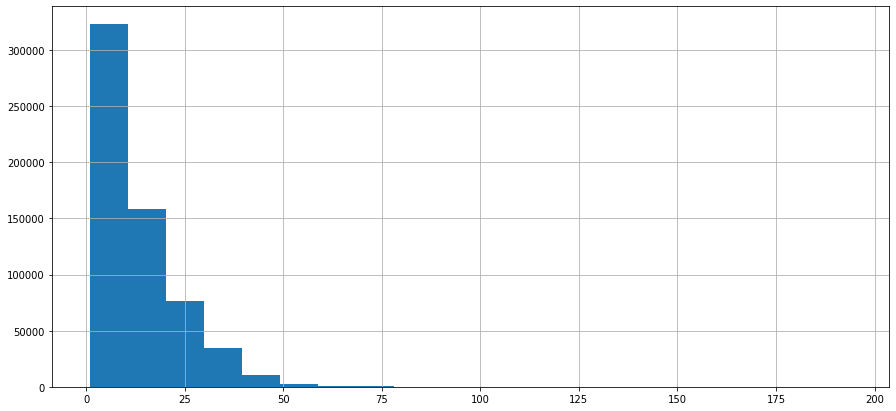

In [152]:
patients['count'].hist(figsize=(15, 7), bins=20)

In [153]:
# A few patients are responsible for the vast majority of claims.
patients['count'].describe()

count    606316.000000
mean         12.801443
std          10.554474
min           1.000000
25%           5.000000
50%          10.000000
75%          18.000000
max         194.000000
Name: count, dtype: float64

In [176]:
procedures = c.groupby('procedure_code').count()

In [180]:
procedures.sort_values(by='count', ascending=False)[:100]

,claim_date,patient_id,provider_zipcode,procedure_charge,claim_month,claim_year,count
procedure_code,,,,,,,
D0120,1133972,1133972,1133972,1133972,1133972,1133972,1133972
D1110,1090847,1090847,1090847,1090847,1090847,1090847,1090847
D0220,589535,589535,589535,589535,589535,589535,589535
D0230,565408,565408,565408,565408,565408,565408,565408
D0274,536264,536264,536264,536264,536264,536264,536264
D1208,374541,374541,374541,374541,374541,374541,374541
D1120,371344,371344,371344,371344,371344,371344,371344
D1206,254966,254966,254966,254966,254966,254966,254966
D0150,246764,246764,246764,246764,246764,246764,246764


In [177]:
procedures[procedures['count'] > 1]

,claim_date,patient_id,provider_zipcode,procedure_charge,claim_month,claim_year,count
procedure_code,,,,,,,
+PA,2,2,2,2,2,2,2
.,4,4,4,4,4,4,4
0000,2,2,2,2,2,2,2
00002,21,21,21,21,21,21,21
00003,1955,1955,1955,1955,1955,1955,1955
...,...,...,...,...,...,...,...
UPGRA,2,2,2,2,2,2,2
UPGRD,2,2,2,2,2,2,2
VITRE,2,2,2,2,2,2,2


In [103]:
# Note that this is when the claim was submitted, not when the procedure actually happened
c['claim_date'] = pd.to_datetime(c['claim_date'])
c['claim_month'] = c['claim_date'].dt.month
c['claim_year'] = c['claim_date'].dt.year

In [143]:
claims = c.groupby('claim_date').count()

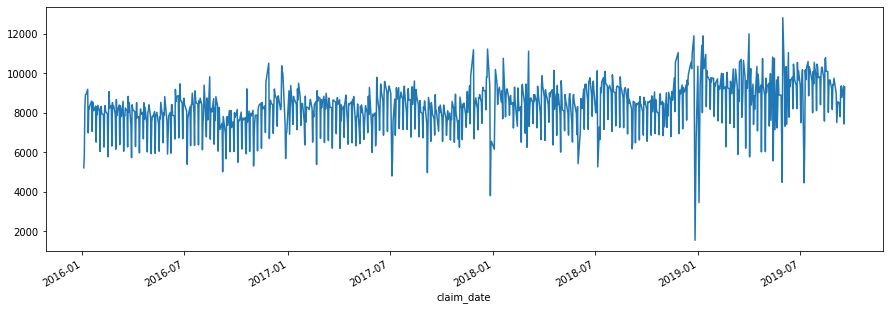

In [144]:
claims['count'].plot(figsize=(15, 5), kind='line')

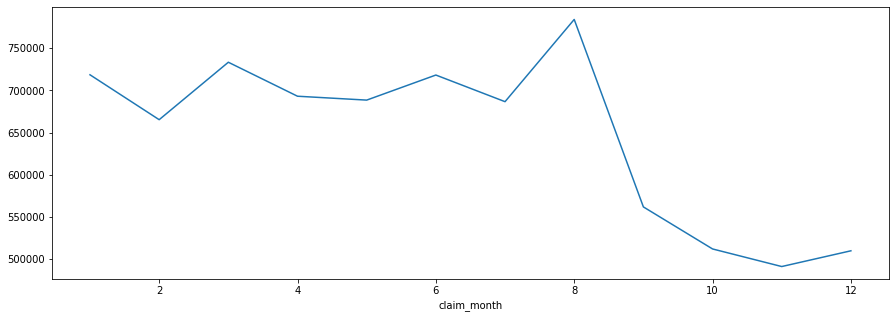

In [146]:
claims_month = c.groupby('claim_month').count()
claims_month['count'].plot(figsize=(15, 5), kind='line')

In [120]:
# 2019 has fewer claims because it's not finished yet
c['claim_date'].max()

Timestamp('2019-09-18 00:00:00')

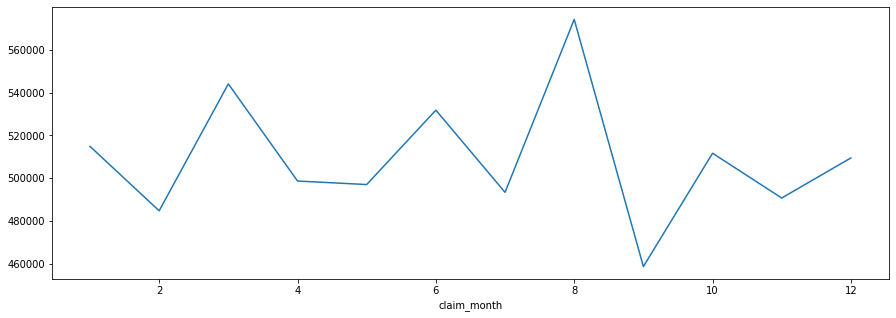

In [148]:
claims_month = c[c['claim_year'] < 2019].groupby('claim_month').count()
claims_month['count'].plot(figsize=(15, 5), kind='line')

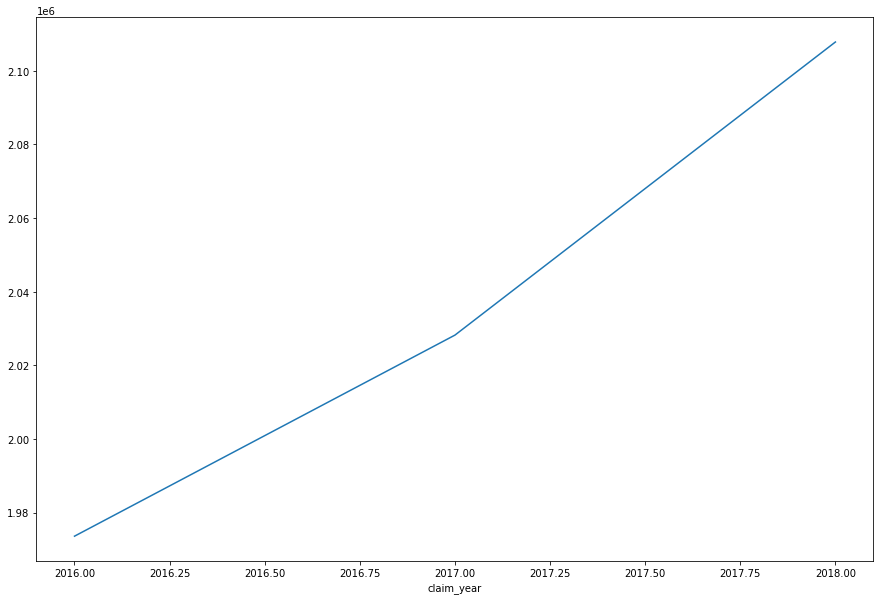

In [149]:
claims_year = c[c['claim_year'] < 2019].groupby('claim_year').count()
claims_year['count'].plot(figsize=(15, 10), kind='line')

In [123]:
claims_per_year = c.groupby(['claim_year', 'claim_date']).count()

In [134]:
# TODO - cumulative claims per year
claims_per_year.cumsum()

patient_id  provider_zipcode  procedure_code  procedure_charge  claim_month
claim_year claim_date                                                                             
2016       2016-01-04        5202              5202            5202              5202         5202
           2016-01-05       11004             11004           11004             11004        11004
           2016-01-06       19292             19292           19292             19292        19292
           2016-01-07       28180             28180           28180             28180        28180
           2016-01-08       37098             37098           37098             37098        37098
...                           ...               ...             ...               ...          ...
2019       2019-09-12     7726884           7726884         7726884           7726884      7726884
           2019-09-13     7735649           7735649         7735649           7735649      7735649
           2019-09-16     7744999           7744999         7744999           7744999      7744999
           2019-09-17     7752420           7752420         7752420           7752420      7752420
           2019-09-18     7761720           7761720         7761720           7761720      7761720

[936 rows x 5 columns]

# Part II - typical procedure prices

In [184]:
c[['procedure_charge']].describe()

,procedure_charge
count,7.761720e+06
mean,1.498749e+02
std,3.915888e+02
min,0.000000e+00
25%,4.600000e+01
50%,7.800000e+01
75%,1.250000e+02
max,9.999900e+04


In [194]:
# Are procedure charges changing over time?
# TODO - investigate
procedure_charge_year = c[['claim_year', 'procedure_code', 'procedure_charge']].groupby(['procedure_code', 'claim_year']).mean()


In [196]:
procedure_charge_year.sort_values

procedure_charge
procedure_code claim_year                  
#D605          2018                   950.0
%0093          2016                   112.0
+PA            2016                    13.0
.              2017                   139.0
.0011          2017                     0.0
...                                     ...
ZD120          2016                    39.0
ZIRCO          2016                   200.0
               2017                   200.0
ZIRCP          2019                   250.0
ZOOMP          2019                     0.0

[4342 rows x 1 columns]

In [186]:
procedure_charge = c[['procedure_code', 'procedure_charge']].groupby(['procedure_code']).mean()

In [189]:
procedure_charge.sort_values(by='procedure_charge', ascending=False)

,procedure_charge
procedure_code,
D7946,16218.75
D6119,11550.00
D7640,10000.00
D7730,6650.00
D6114,6323.60
...,...
D0154,0.00
D0181,0.00
D9949,0.00


In [190]:
# Why are these charges 0?
procedure_charge[procedure_charge['procedure_charge'] == 0]

,procedure_charge
procedure_code,
.0011,0.0
00004,0.0
0000V,0.0
000CR,0.0
0011R,0.0
00BAL,0.0
00TAX,0.0
01203,0.0
10001,0.0


In [208]:
category_unique = pc['coverage_category'].unique()
category = {key: idx for idx, key in enumerate(category_unique)}
category

{'ORAL_EVALUATION': 0,
 'NOT_COVERED': 1,
 'XRAY': 2,
 'TEST': 3,
 'PROPHYLAXIS': 4,
 'FLUORIDE': 5,
 'SEALANT': 6,
 'SPACE_MAINTAINER': 7,
 'RESTORATION': 8,
 'INLAY_ONLAY_CROWN': 9,
 'SIMPLE_REPAIR': 10,
 'ENDODONTIC': 11,
 'PERIODONTIC': 12,
 'DENTURE': 13,
 'OTHER_PROSTHETIC': 14,
 'BRIDGE': 15,
 'SIMPLE_EXTRACTION': 16,
 'SURGICAL_EXTRACTION': 17,
 'ORAL_SURGERY': 18,
 'ORTHODONTIC': 19,
 'EMERGENCY_PALLIATIVE': 20,
 'ANESTHESIA': 21}

In [207]:
sub_category_unique = pc['sub_category'].unique()
sub_category = {key: idx for idx, key in enumerate(sub_category_unique)}
sub_category

{'ORAL_EVALUATION': 0,
 'NOT_COVERED': 1,
 'COMPLETE_SERIES': 2,
 'XRAY': 3,
 'BITEWING': 4,
 'ADVANCED_IMAGING': 5,
 'TEST': 6,
 'PROPHYLAXIS': 7,
 'FLUORIDE': 8,
 'SEALANT': 9,
 'SPACE_MAINTAINER': 10,
 'AMALGAM': 11,
 'COMPOSITE': 12,
 'GOLD_FOIL': 13,
 'INLAY_ONLAY_CROWN': 14,
 'RESTORATION': 15,
 'SIMPLE_REPAIR': 16,
 'ENDODONTIC': 17,
 'PERIODONTIC': 18,
 'DENTURE': 19,
 'OTHER_PROSTHETIC': 20,
 'BRIDGE': 21,
 'SIMPLE_EXTRACTION': 22,
 'SURGICAL_EXTRACTION': 23,
 'ORAL_SURGERY': 24,
 'ORTHODONTIC': 25,
 'EMERGENCY_PALLIATIVE': 26,
 'ANESTHESIA': 27}

In [211]:
pc[['coverage_category', 'sub_category']]

,coverage_category,sub_category
0,ORAL_EVALUATION,ORAL_EVALUATION
1,ORAL_EVALUATION,ORAL_EVALUATION
2,ORAL_EVALUATION,ORAL_EVALUATION
3,ORAL_EVALUATION,ORAL_EVALUATION
4,ORAL_EVALUATION,ORAL_EVALUATION
...,...,...
700,NOT_COVERED,NOT_COVERED
701,NOT_COVERED,NOT_COVERED
702,NOT_COVERED,NOT_COVERED
703,NOT_COVERED,NOT_COVERED


In [214]:
pc[['coverage_category', 'sub_category']].values

array([['ORAL_EVALUATION', 'ORAL_EVALUATION'],
       ['ORAL_EVALUATION', 'ORAL_EVALUATION'],
       ['ORAL_EVALUATION', 'ORAL_EVALUATION'],
       ...,
       ['NOT_COVERED', 'NOT_COVERED'],
       ['NOT_COVERED', 'NOT_COVERED'],
       ['NOT_COVERED', 'NOT_COVERED']], dtype=object)

In [253]:
j = procedure_charge.join(pc.set_index('procedure_code'))
j[~j['coverage_category'].isna()]

,procedure_charge,description,tier,unit,sub_category,coverage_category
procedure_code,,,,,,
D0120,61.320648,Periodic oral evaluation - established patient,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
D0140,85.834426,Limited oral evaluation - problem focused,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
D0145,74.215822,Oral evaluation for a patient under three year...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
D0150,92.111971,Comprehensive oral evaluation - new or establi...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
D0160,150.237273,Detailed and extensive oral evaluation - probl...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
...,...,...,...,...,...,...
D9993,69.048580,Dental case management - motivational intervie...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
D9994,22.000000,Dental case management - patients education to...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
D9995,60.222222,Teledentistry - synchronous: real-time encounter,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED


In [254]:
j = j.reindex()
j = j.groupby(['procedure_code', 'coverage_category']).mean().drop('unit', axis=1)
j = j.join(pc.set_index('procedure_code'))
j

,,procedure_charge,description,tier,unit,sub_category,coverage_category
procedure_code,coverage_category,,,,,,
D0120,ORAL_EVALUATION,61.320648,Periodic oral evaluation - established patient,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
D0140,ORAL_EVALUATION,85.834426,Limited oral evaluation - problem focused,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
D0145,ORAL_EVALUATION,74.215822,Oral evaluation for a patient under three year...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
D0150,ORAL_EVALUATION,92.111971,Comprehensive oral evaluation - new or establi...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
D0160,ORAL_EVALUATION,150.237273,Detailed and extensive oral evaluation - probl...,TIER_1,1.0,ORAL_EVALUATION,ORAL_EVALUATION
...,...,...,...,...,...,...,...
D9993,NOT_COVERED,69.048580,Dental case management - motivational intervie...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
D9994,NOT_COVERED,22.000000,Dental case management - patients education to...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
D9995,NOT_COVERED,60.222222,Teledentistry - synchronous: real-time encounter,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED


In [255]:
j.sort_values(by='procedure_charge', ascending=False)[:100]

,,procedure_charge,description,tier,unit,sub_category,coverage_category
procedure_code,coverage_category,,,,,,
D7946,ORAL_SURGERY,16218.750000,LeFort I (maxilla - total),TIER_2,NaN,ORAL_SURGERY,ORAL_SURGERY
D6119,NOT_COVERED,11550.000000,Implant /abutment supported interim fixed dent...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
D7640,ORAL_SURGERY,10000.000000,Mandible - closed reduction (teeth immobilized...,TIER_2,NaN,ORAL_SURGERY,ORAL_SURGERY
D7730,ORAL_SURGERY,6650.000000,Mandible - open reduction,TIER_2,NaN,ORAL_SURGERY,ORAL_SURGERY
D6114,NOT_COVERED,6323.600000,Implant /abutment supported fixed denture for ...,NOT_COVERED,NaN,NOT_COVERED,NOT_COVERED
D7947,ORAL_SURGERY,6249.000000,LeFort I (maxilla - segmented),TIER_2,NaN,ORAL_SURGERY,ORAL_SURGERY
D8090,ORTHODONTIC,5525.113727,Comprehensive orthodontic treatment of the adu...,TIER_4,NaN,ORTHODONTIC,ORTHODONTIC
D8080,ORTHODONTIC,5395.068861,Comprehensive orthodontic treatment of the ado...,TIER_4,NaN,ORTHODONTIC,ORTHODONTIC
D7941,ORAL_SURGERY,5295.666667,Osteotomy - mandibular rami,TIER_2,NaN,ORAL_SURGERY,ORAL_SURGERY


In [ ]:
j[j['procedure_charge'] > 0].sort_values(by='procedure_charge', ascending=False)['procedure_charge']